In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from lagged_coherence import *
import colorednoise as cn
import scipy

In [2]:
def compute_rms(time_series):
    return np.sqrt(np.mean(np.square(time_series)))

def scale_noise(signal_without_noise, noise, desired_snr_db):
    # Compute power of the original signal
    Ps = compute_rms(signal_without_noise)**2
    
    # Convert desired SNR from dB to linear scale
    snr_linear = 10**(desired_snr_db / 10)
    
    # Calculate the desired noise power based on the desired SNR
    desired_noise_power = Ps / snr_linear
    
    # Compute scaling factor for the noise
    alpha = np.sqrt(desired_noise_power / compute_rms(noise)**2)
    
    return alpha * noise

def gen_signal(T, trials, srate, fs, snr_db):
    time=np.linspace(0,T,T*srate)
    
    w = 2. * np.pi * f
    signal=np.zeros((trials,len(time)))
    for i in range(trials):
        pure_signal = np.sin(w * (time + np.random.randn()))
        noise = cn.powerlaw_psd_gaussian(1, len(time))
        scaled_noise = scale_noise(pure_signal, noise, snr_db)        
        
        signal[i,:]=pure_signal+scaled_noise
        
    return signal

In [3]:
T=5
trials=10
srate=1000
snr=0

lags=np.arange(1,6.5,.5)
f=25

f_min=5
f_max=100
n_freqs=((f_max-f_min)*2)+1

print('{}Hz'.format(f))
signal=gen_signal(T, trials, srate, f, snr)

freqs, psd = scipy.signal.welch(signal, fs=srate, window='hann',
                                nperseg=srate, noverlap=int(srate / 2), nfft=srate * 2, detrend='constant',
                                return_onesided=True, scaling='density', axis=- 1, average='mean')
idx=(freqs>=f_min) & (freqs<=f_max)
freqs=freqs[idx]
psd=psd[:,idx]

lcs_hilbert=lagged_hilbert_coherence(signal, freqs, lags, srate, n_jobs=2, type='coh')
lplvs_hilbert=lagged_hilbert_coherence(signal, freqs, lags, srate, n_jobs=2, type='plv')
lacs_hilbert=lagged_hilbert_coherence(signal, freqs, lags, srate, n_jobs=2, type='amp_coh')

25Hz


Text(0, 0.5, 'Frequency (Hz)')

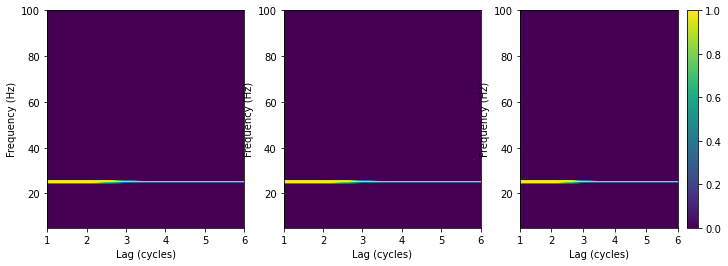

In [5]:
fig=plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
im=ax.imshow(np.mean(lcs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,2)
im=ax.imshow(np.mean(lplvs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,3)
im=ax.imshow(np.mean(lacs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')


In [6]:
signal.shape

(10, 5000)

In [7]:
# 1. Randomly shuffling the time points of each trial independently
shuffled_time_points = np.array([np.random.permutation(trial) for trial in signal])

# 2. Randomly shuffling the phase of each trial independently
def shuffle_phase(trial):
    analytic_signal = hilbert(trial)
    amplitude = np.abs(analytic_signal)
    phase = np.angle(analytic_signal)
    random_phase = np.exp(1j * np.random.permutation(phase))
    return np.real(amplitude * random_phase)

shuffled_phase = np.array([shuffle_phase(trial) for trial in signal])

# 3. Randomly shuffling the amplitude of each trial independently
def shuffle_amplitude(trial):
    analytic_signal = hilbert(trial)
    amplitude = np.abs(analytic_signal)
    phase = np.angle(analytic_signal)
    shuffled_amplitude = np.random.permutation(amplitude)
    return np.real(shuffled_amplitude * np.exp(1j * phase))

shuffled_amplitude = np.array([shuffle_amplitude(trial) for trial in signal])

Text(0, 0.5, 'Frequency (Hz)')

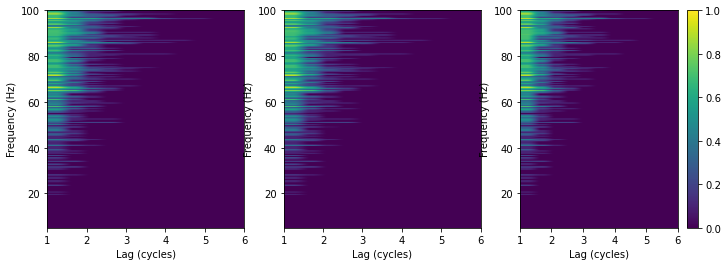

In [8]:
lcs_hilbert=lagged_hilbert_coherence(shuffled_time_points, freqs, lags, srate, n_jobs=2, type='coh')
lplvs_hilbert=lagged_hilbert_coherence(shuffled_time_points, freqs, lags, srate, n_jobs=2, type='plv')
lacs_hilbert=lagged_hilbert_coherence(shuffled_time_points, freqs, lags, srate, n_jobs=2, type='amp_coh')

fig=plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
im=ax.imshow(np.mean(lcs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,2)
im=ax.imshow(np.mean(lplvs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,3)
im=ax.imshow(np.mean(lacs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')


Text(0, 0.5, 'Frequency (Hz)')

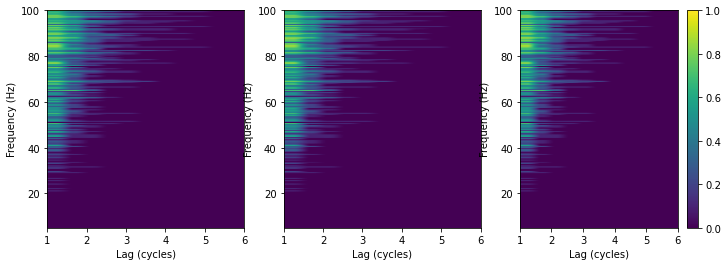

In [9]:
lcs_hilbert=lagged_hilbert_coherence(shuffled_phase, freqs, lags, srate, n_jobs=2, type='coh')
lplvs_hilbert=lagged_hilbert_coherence(shuffled_phase, freqs, lags, srate, n_jobs=2, type='plv')
lacs_hilbert=lagged_hilbert_coherence(shuffled_phase, freqs, lags, srate, n_jobs=2, type='amp_coh')

fig=plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
im=ax.imshow(np.mean(lcs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,2)
im=ax.imshow(np.mean(lplvs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,3)
im=ax.imshow(np.mean(lacs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')


Text(0, 0.5, 'Frequency (Hz)')

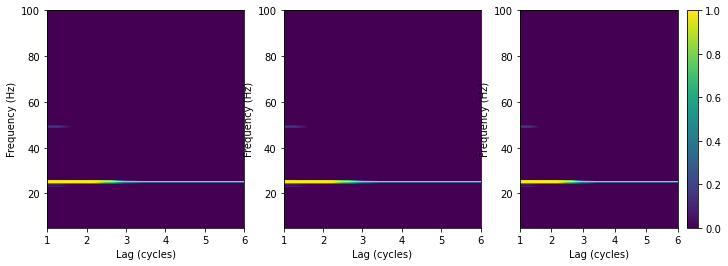

In [10]:
lcs_hilbert=lagged_hilbert_coherence(shuffled_amplitude, freqs, lags, srate, n_jobs=2, type='coh')
lplvs_hilbert=lagged_hilbert_coherence(shuffled_amplitude, freqs, lags, srate, n_jobs=2, type='plv')
lacs_hilbert=lagged_hilbert_coherence(shuffled_amplitude, freqs, lags, srate, n_jobs=2, type='amp_coh')

fig=plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
im=ax.imshow(np.mean(lcs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,2)
im=ax.imshow(np.mean(lplvs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')

ax=plt.subplot(1,3,3)
im=ax.imshow(np.mean(lacs_hilbert,axis=0), extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im)
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('Frequency (Hz)')
